In [1]:


import tensorflow as tf
import matplotlib.pyplot as plt
import numpy
import os

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:

# MNIST 데이터 불러오기
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()
## X_train shape : ( 이미지 장수, 이미지 가로 , 이미지 세로 )
## Y_train : (정답 갯수, ) - > [ 0 ,1, 2, 4 ,5, 5, ....  ]


In [3]:

## X_train shape : ( 이미지 장수, 가로 , 세로 ) 이차원 이어서 Neural Network(=Multi Layer Perceptron ) 입력 차원인 1차원으로
## 변경 해주어야 합니다.
## reshape 사용하여 차원 변형
X_train = X_train.reshape(X_train.shape[0], 784).astype('float32')  ## 28x28= 784
X_test = X_test.reshape(X_test.shape[0], 784).astype('float32')


In [4]:

##  [ 0 ,1, 2, 4 ,5, 5, ....  ] -> [ [1 0 0 0 0 0 0 0], [0 1 0 0 0 0 0.. ] , ] 원핫인코딩
Y_train = tf.keras.utils.to_categorical(Y_train)
Y_test =  tf.keras.utils.to_categorical(Y_test)


In [5]:

#모델 설계
# method 1
input_Layer = tf.keras.layers.Input(shape=(784,)) ## 데이터 입력
x = tf.keras.layers.Dense(512, activation=None)(input_Layer) # hidden layer1
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dense(512, activation=None)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
## out은 task를 수행.
## 10개의 class를 분류해야힘
## 분류해야하는 class  0~ 9: 10개 그래서 아웃풋 perceptron 10개
## 각각의 perceptron이 출력값을 가지면 -> 상관관계가 없음.
## 출력을 확률 처럼 맵핑 하고자 softmax 를 사용하면
# 출력이 확률처럼나오게 된다. 때문에 멀티 클레스피케이션에서 softmax를 쓰는게 일반적.
Out_Layer= tf.keras.layers.Dense(10, activation='softmax')(x)  ## 분류해야하는 class  0~ 9: 10개 그래서 아웃풋 perceptron 10개

model = tf.keras.Model(inputs=[input_Layer], outputs=[Out_Layer])
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [6]:

# 모델 컴파일
loss=tf.keras.losses.categorical_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
metric=tf.keras.metrics.categorical_accuracy
model.compile(loss=loss,
             optimizer=optimizer,
             metrics=[metric])

# 베스트 모델 저장을 위한 디렉토리 선언
MODEL_DIR = './MNIST_model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

## 저장한 모델의 주소와 이름.
modelpath="./MNIST_model/{epoch:02d}-{val_loss:.4f}.hdf5"

## 사용할 callback 함수 선언.
callback_list=[tf.keras.callbacks.ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True),
               tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]

# 모델의 실행
#  validation_data 옵션으로 테스트 데이터만 넣어주어서 검증 데이터 분류가 가능
result = model.fit(X_train, Y_train, validation_split=0.2, epochs=30, batch_size=1000, verbose=1, callbacks=callback_list)
print(result.history.keys())



Epoch 1/30
48/48 [==============================] - 2s 15ms/step - loss: 15.1137 - categorical_accuracy: 0.7955 - val_loss: 1.2714 - val_categorical_accuracy: 0.9237

Epoch 00001: val_loss improved from inf to 1.27139, saving model to ./MNIST_model/01-1.2714.hdf5
Epoch 2/30
48/48 [==============================] - 1s 11ms/step - loss: 0.8305 - categorical_accuracy: 0.9334 - val_loss: 0.7555 - val_categorical_accuracy: 0.9339

Epoch 00002: val_loss improved from 1.27139 to 0.75548, saving model to ./MNIST_model/02-0.7555.hdf5
Epoch 3/30
48/48 [==============================] - 1s 11ms/step - loss: 0.3748 - categorical_accuracy: 0.9559 - val_loss: 0.6127 - val_categorical_accuracy: 0.9409

Epoch 00003: val_loss improved from 0.75548 to 0.61269, saving model to ./MNIST_model/03-0.6127.hdf5
Epoch 4/30
48/48 [==============================] - 1s 11ms/step - loss: 0.1975 - categorical_accuracy: 0.9706 - val_loss: 0.5688 - val_categorical_accuracy: 0.9423

Epoch 00004: val_loss improved from 

313/313 [==============================] - 1s 3ms/step - loss: 0.4100 - categorical_accuracy: 0.9567

 Test Accuracy: 0.9567


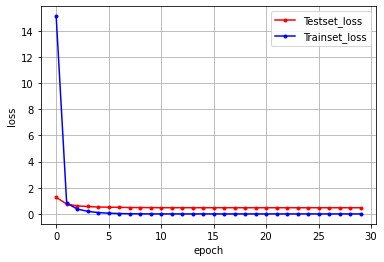

In [7]:
# 테스트 정확도 출력
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, Y_test)[1]))
# 테스트 셋의 오차
val_loss = result.history['val_loss']

# 학습셋의 오차
loss = result.history['loss']

# 그래프로 표현
x_len = numpy.arange(len(val_loss))
plt.plot(x_len, val_loss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
# plt.axis([0, 20, 0, 0.35])
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()